In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [2]:
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output, hidden = self.lstm(embedded, hidden)
        output = output.contiguous().view(-1, self.hidden_size)  # (batch_size*sequence_length, hidden_size)
        output = self.fc(output)  # (batch_size*sequence_length, num_classes)
        return output, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return (weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device),
                weight.new(self.n_layers, batch_size, self.hidden_size).zero_().to(device))

In [3]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

class TextDataset(Dataset):
    def __init__(self, text, seq_length=200, batch_size=64):
        self.text = text
        self.seq_length = seq_length
        self.batch_size = batch_size

    def __len__(self):
        return len(self.text) - self.seq_length

    def __getitem__(self, idx):
        sequence = self.text[idx:idx+self.seq_length]
        label = self.text[idx+1:idx+self.seq_length+1]
    
        return char_tensor(sequence), char_tensor(label)

# assuming that `text.txt` is your file and it's located at the current directory.
with open('shakespeare.txt', 'r') as f:
    text = f.read()

all_characters = sorted(list(set(text)))
input_size = len(all_characters)
output_size = len(all_characters)

Epoch [1/10], Step [0/8713], Loss: 4.1690
Epoch [1/10], Step [1000/8713], Loss: 1.5223
Epoch [1/10], Step [2000/8713], Loss: 1.3995
Epoch [1/10], Step [3000/8713], Loss: 1.3423
Epoch [1/10], Step [4000/8713], Loss: 1.2957
Epoch [1/10], Step [5000/8713], Loss: 1.2988
Epoch [1/10], Step [6000/8713], Loss: 1.2670
Epoch [1/10], Step [7000/8713], Loss: 1.2440
Epoch [1/10], Step [8000/8713], Loss: 1.2520
Epoch [2/10], Step [0/8713], Loss: 1.2328
Epoch [2/10], Step [1000/8713], Loss: 1.2035
Epoch [2/10], Step [2000/8713], Loss: 1.2148
Epoch [2/10], Step [3000/8713], Loss: 1.1872
Epoch [2/10], Step [4000/8713], Loss: 1.2046
Epoch [2/10], Step [5000/8713], Loss: 1.1801
Epoch [2/10], Step [6000/8713], Loss: 1.1825
Epoch [2/10], Step [7000/8713], Loss: 1.1859
Epoch [2/10], Step [8000/8713], Loss: 1.1627
Epoch [3/10], Step [0/8713], Loss: 1.1686
Epoch [3/10], Step [1000/8713], Loss: 1.1354
Epoch [3/10], Step [2000/8713], Loss: 1.1485
Epoch [3/10], Step [3000/8713], Loss: 1.1558
Epoch [3/10], Step 

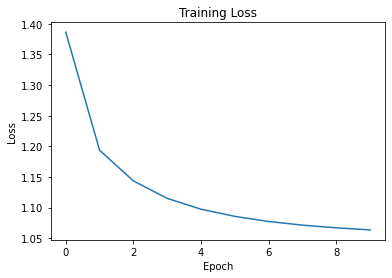

In [4]:
# Define hyperparameters
batch_size = 126
hidden_size = 128
n_layers = 2
learning_rate = 0.001
n_epochs = 10
print_every = 1000
plot_every = 100

# Create the dataset and data loader
dataset = TextDataset(text)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize the model and move it to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CharRNN(input_size, hidden_size, output_size, n_layers).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Track the training loss over epochs
all_losses = []

# Set the start hidden state
hidden = model.init_hidden(128)

# Training loop
for epoch in range(1, n_epochs + 1):
    total_loss = 0.0
    #hidden = model.init_hidden(batch_size)
    for i, (input_batch, target_batch) in enumerate(itertools.islice(dataloader, len(dataloader)-1)):
            
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        optimizer.zero_grad()

        hidden = (hidden[0].detach(), hidden[1].detach())  # Detach the hidden state

        output, hidden = model(input_batch, hidden)

        loss = criterion(output.view(-1, output_size), target_batch.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if i % print_every == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' % (epoch, n_epochs, i, len(dataloader), loss.item()))

    all_losses.append(total_loss / len(dataloader))

    if epoch % plot_every == 0:
        plt.plot(all_losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

# Plot the final training loss
plt.plot(all_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [7]:
# Set the model to evaluation mode
model.eval()

# Set the sequence length
sequence_length = 5000

# Initialize the hidden state
hidden = model.init_hidden(1)
hidden = tuple(h.to(device) for h in hidden)  # Move the hidden state to the same device as the model

# Choose a starting character or seed
start_char = 'C'

# Convert the starting character to a tensor
input_tensor = char_tensor(start_char).unsqueeze(0).to(device)  # Move the input tensor to the same device as the model

# Create an empty list to store the generated sequence
generated_sequence = []

# Loop through each step of sequence generation
for _ in range(sequence_length):
    # Pass the input tensor and hidden state to the model
    output, hidden = model(input_tensor, hidden)

    # Move the output tensor to the CPU
    output = output.cpu()

    # Sample the next character from the output distribution
    next_char_tensor = torch.multinomial(torch.exp(output.view(-1)), 1)
    next_char = all_characters[next_char_tensor.item()]

    # Append the sampled character to the generated sequence
    generated_sequence.append(next_char)

    # Set the input character for the next step as the sampled character
    input_tensor = char_tensor(next_char).unsqueeze(0).to(device)  # Move the input tensor to the same device as the model

# Join the generated sequence into a string
generated_sequence = ''.join(generated_sequence)

# Print the generated sequence
print(generated_sequence)

IBQLA3aketuch forth.
Your best wingatager: they loose this delight
A grave yourself; teach upon thy foesing roar with us.

BIONDELLO:
Where issues that vows for my great night at the daughters!
Sorran he is, will I such, for nor ears,
Or in that debt of all all cheek of it:
If ever I be, if the potily!

CAMILLO:
It shall not have an enemy, with war;
Or hath stop not your lordship, if I take for overhas's labour,
And have been more woes looks asleep.'
And tell me, and no other have I scatch.

TRANIO:
Year,' quote doth the dear,
Or pluck'd their corps of pecrities
That I lie the death of storeles of his
homen of is mourning Cartse love,
O' the subsider means their joysell!
Thrushed vimous ere no other blessed dukel:
But with sacundchood remedy, would be
be power is thee withord. The beggar ever, draw
are hold
Should be offern'd lions country, ground
Before you know them both.

Second O shall fetch pursuit trouble your trie to know:
Henceforwh, the very men,
Despised and not both I'll cru